In [1]:
print('Setting UP')
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.python.keras.callbacks import EarlyStopping
from utils import *
%matplotlib inline

Setting UP


In [2]:
batch_data_size = 5  # 32
steering_mapping = {'forward': 0, 'left': 1, 'right': 2}
image_data_directory = 'data_collected'

In [3]:
image_dataframe = import_data(image_data_directory)
print(image_dataframe.shape)
print(image_dataframe.head())

10:8611:7912:8313:7314:8115:8016:8017:7718:8119:7920:7921:81total imported images 959
(959, 2)
                             Center Steering
0  IMG10/Image_1716802417094264.jpg     left
1  IMG10/Image_1716802418141973.jpg  forward
2  IMG10/Image_1716802419189981.jpg  forward
3  IMG10/Image_1716802420216215.jpg  forward
4  IMG10/Image_1716802421248789.jpg  forward


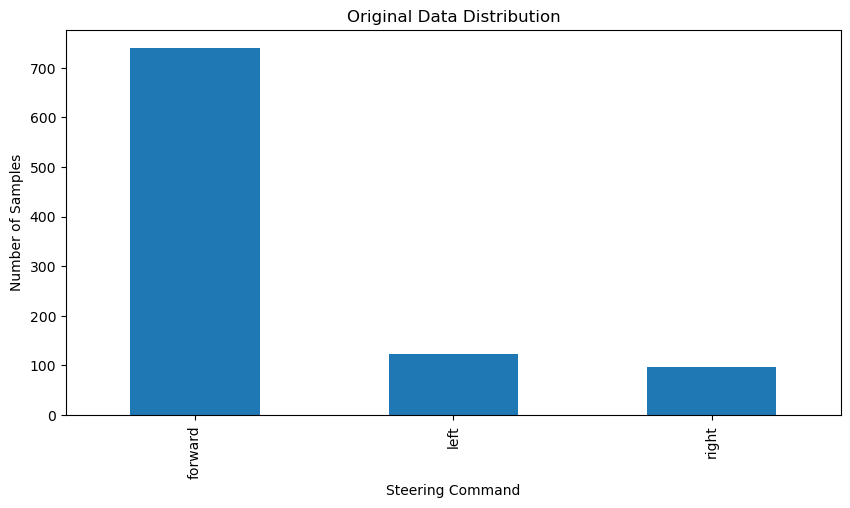

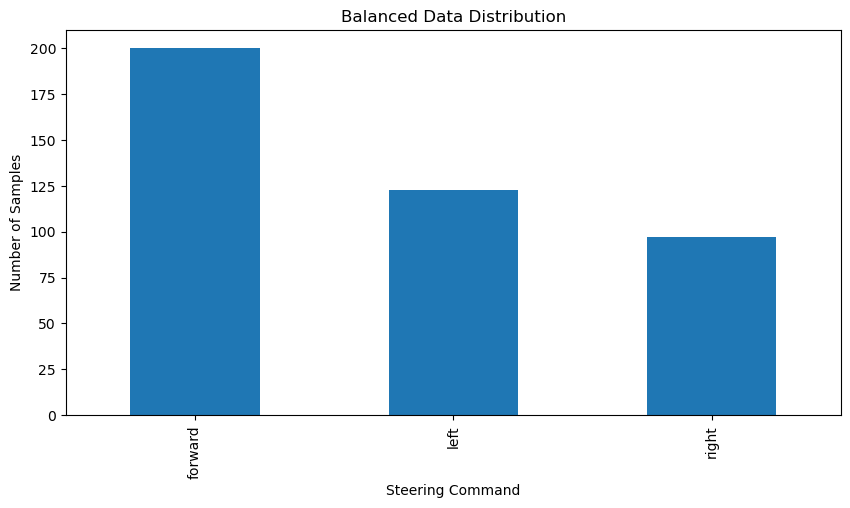

Removed Images: 539
Remaining Images: 420
                              Center Steering  Steering_forward  \
0   IMG10/Image_1716802417094264.jpg     left               0.0   
5   IMG10/Image_1716802422276296.jpg     left               0.0   
7   IMG10/Image_1716802424335807.jpg  forward               1.0   
10  IMG10/Image_1716802427461581.jpg     left               0.0   
11   IMG10/Image_171680242853871.jpg     left               0.0   

    Steering_left  Steering_right  
0             1.0             0.0  
5             1.0             0.0  
7             0.0             0.0  
10            1.0             0.0  
11            1.0             0.0  


In [4]:
# balance data
image_dataframe = balance_data(image_dataframe, display=True)  # vis and balance
print(image_dataframe.head())

In [5]:
# preprocess
images_path, steering, steering_forward, steering_left, steering_right = load_data(
    image_data_directory,
    image_dataframe)

print(f' image_path :: {len(images_path)} steering :: {len(steering)} steering_forward :: {len(steering_forward)} '
      f'steering_left :: {len(steering_left)} steering_right {len(steering_right)}')

 image_path :: 420 steering :: 420 steering_forward :: 420 steering_left :: 420 steering_right 420


In [6]:
# split: validation and train setup
data_frame = pd.DataFrame({
      'images_path': images_path,
      'steering': steering,
      'steering_forward': steering_forward,
      'steering_left': steering_left,
      'steering_right': steering_right
})

X = data_frame[['images_path', 'steering_forward', 'steering_left', 'steering_right']]
y = data_frame[['steering_forward', 'steering_left', 'steering_right']]

print(X.head())


                                       images_path  steering_forward  \
0  data_collected/IMG10/Image_1716802417094264.jpg               0.0   
1  data_collected/IMG10/Image_1716802422276296.jpg               0.0   
2  data_collected/IMG10/Image_1716802424335807.jpg               1.0   
3  data_collected/IMG10/Image_1716802427461581.jpg               0.0   
4   data_collected/IMG10/Image_171680242853871.jpg               0.0   

   steering_left  steering_right  
0            1.0             0.0  
1            1.0             0.0  
2            0.0             0.0  
3            1.0             0.0  
4            1.0             0.0  


In [7]:
xTrain, xVal, yTrain, yVal = train_test_split(
      X,
      y,
      test_size=0.2,
      random_state=10
)
print(f'total training Images: {len(xTrain)}')
print(f'total validation Images: {len(xVal)}')

total training Images: 336
total validation Images: 84


In [8]:
# data generators (training and validation)
train_generator = tf.data.Dataset.from_generator(
    lambda: data_generator(
        xTrain['images_path'].values,
        xTrain['steering_forward'].values,
        xTrain['steering_left'].values,
        xTrain['steering_right'].values,
        batch_size=batch_data_size,
        train_flag=True
    ),
    output_signature=(
        {
            'image_input': tf.TensorSpec(shape=(None, 66, 200, 3), dtype=tf.float32),
            'numerical_input': tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
)

validation_generator = tf.data.Dataset.from_generator(
    lambda: data_generator(
        xVal['images_path'].values,
        xVal['steering_forward'].values,
        xVal['steering_left'].values,
        xVal['steering_right'].values,
        batch_size=batch_data_size,
        train_flag=False
    ),
    output_signature=(
        {
            'image_input': tf.TensorSpec(shape=(None, 66, 200, 3), dtype=tf.float32),
            'numerical_input': tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
    )
)

2024-05-27 15:58:40.900834: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-27 15:58:40.900862: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-27 15:58:40.900866: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-27 15:58:40.901207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-27 15:58:40.901230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# model
model = create_model()
print(model.summary())

# we have more forwards
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(yTrain, axis=1)),
    y=np.argmax(yTrain, axis=1)
)
class_weights_dictionary = {i: class_weights[i] for i in range(len(class_weights))}
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 66, 200,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 98,    │      1,824 │ image_input[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 47,    │     21,636 │ conv2d[0][0]      │
│                     │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 5, 22, 48) │     43,248 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 20, 64) │     27,712 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 18, 64) │     36,928 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │    115,300 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │        128 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      5,050 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │        528 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        510 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8)         │        136 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 18)        │          0 │ dense_2[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 50)        │        950 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        510 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         11 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 254,471 (994.03 KB)

 Trainable params: 254,471 (994.03 KB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# train
history = model.fit(
    train_generator,
    steps_per_epoch=len(xTrain) // batch_data_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(xVal) // batch_data_size,
    class_weight=class_weights_dictionary,
    callbacks=[early_stopping]
)
model.save('model.keras')
print('Model Saved')


Epoch 1/10


2024-05-27 15:58:42.178604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - loss: 0.3059 - mae: 0.3380 - mse: 0.3296 - val_loss: 0.3096 - val_mae: 0.3459 - val_mse: 0.3096
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - loss: 0.2934 - mae: 0.3593 - mse: 0.2943 - val_loss: 0.2257 - val_mae: 0.4623 - val_mse: 0.2257
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - loss: 0.2100 - mae: 0.4456 - mse: 0.2250 - val_loss: 0.2225 - val_mae: 0.4418 - val_mse: 0.2225
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - loss: 0.2200 - mae: 0.4408 - mse: 0.2250 - val_loss: 0.2227 - val_mae: 0.4398 - val_mse: 0.2227
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - loss: 0.2104 - mae: 0.4423 - mse: 0.2241 - val_loss: 0.2230 - val_mae: 0.4511 - val_mse: 0.2230
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - loss: 0.2386 - mae: 0.4417 - mse: 0.2246 - val_loss: 0.2226 - val_mae: 0.4466 - val_mse: 0.2226
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - loss: 0.2212 - mae: 0.4436 - mse: 0.2239 - val_los

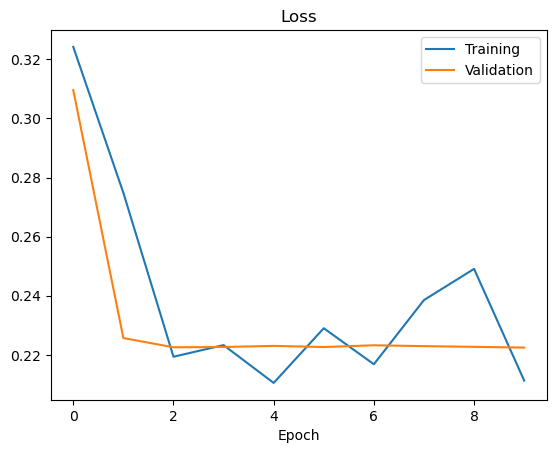

In [11]:
# results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [12]:
# Evaluate model
test_loss, test_mae, test_mse = model.evaluate(validation_generator, steps=len(xVal) // batch_data_size)
# test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(xVal) // batch_data_size)
print(f'Test Loss: {test_loss}')
print(f'Test mae: {test_mae}')
print(f'Test mae: {test_mse}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2227 - mae: 0.4391 - mse: 0.2227
Test Loss: 0.22252310812473297
Test mae: 0.44121235609054565
Test mae: 0.22252310812473297


In [13]:

for j in range(0, len(data_frame)):
    images_path_0 = data_frame.iloc[j]['images_path']
    steering_0 = data_frame.iloc[j]['steering']
    steering_forward_0 = data_frame.iloc[j]['steering_forward']
    steering_left_0 = data_frame.iloc[j]['steering_left']
    steering_right_0 = data_frame.iloc[j]['steering_right']

    prediction = test_model(model, images_path_0, steering_0,
                            steering_forward_0, steering_left_0, steering_right_0)
    print(f'image {images_path_0} Recorded vs Prediction : {steering_0} : {prediction}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Prediction for the test image: [[0.31307715]]
image data_collected/IMG10/Image_1716802417094264.jpg Recorded vs Prediction : left : left
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction for the test image: [[0.31150222]]
image data_collected/IMG10/Image_1716802422276296.jpg Recorded vs Prediction : left : left
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction for the test image: [[0.3318928]]
image data_collected/IMG10/Image_1716802424335807.jpg Recorded vs Prediction : forward : forward
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Prediction for the test image: [[0.33401787]]
image data_collected/IMG10/Image_1716802427461581.jpg Recorded vs Prediction : left : forward
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction for the test image: [[0.33032888]]
image data_collected/IMG10/Image_171680242853871.jpg Recorded vs Prediction : left : forward
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for the test image: [[0.3492294]]
image data_collected/IMG10/Imag

In [14]:
# # Define a representative dataset function for quantization
# def representative_data_gen():
#     for input_value in validation_generator.take(100):  # Take a subset of your validation data
#         # The inputs should be in the same shape as expected by the model
#         yield [input_value[0]['image_input'].astype(np.float32), input_value[0]['numerical_input'].astype(np.float32)]


# saved_model = tf.keras.models.load_model('model.keras')

# converter = tf.lite.TFLiteConverter.from_keras_model(saved_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.uint8  # or tf.float32
# converter.inference_output_type = tf.uint8  # or tf.float32

# tflite_model = converter.convert()

# # Save the quantized model to a file
# with open('model_quantized.tflite', 'wb') as f:
#     f.write(tflite_model)

# print("Quantized model saved as model_quantized.tflite")